### The XGBOOST Model


In case you are interessted in machine learning, here are some good sources:

- [Bias and Variance](https://www.youtube.com/watch?v=EuBBz3bI-aA&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=5)
- [Decision Trees](https://www.youtube.com/watch?v=7VeUPuFGJHk&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=34)
- [Regression Trees](https://www.youtube.com/watch?v=g9c66TUylZ4&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=36)
- [Random Forest / parallel ensemble learning](https://www.youtube.com/watch?v=EuBBz3bI-aA&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=5)
- [Adaptive Boosting / sequential ensemble learning](https://www.youtube.com/watch?v=LsK-xG1cLYA&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=43)
- [Gradient Boosting / sequential ensemble learning](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=44)
- [Extreme gradient boosting](https://www.youtube.com/watch?v=OtD8wVaFm6E&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=54)
- [Deep Learning/Neural Networks vs Machine Learning](https://towardsdatascience.com/predicting-airbnb-prices-with-machine-learning-and-deep-learning-f46d44afb8a6)

The following contains the Model/Machine Learning algorithm for the price prediction. Further it contains some more data cleaning since the results of the model necessitated it. 

In [1]:
# import all the moduls
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression

from xgboost.sklearn import XGBRegressor
import sklearn
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter
import geopandas as gpd
import numpy as np
import seaborn as sns

In [2]:
# read pre cleaned data with accessibility score
df = pd.read_csv(r'./Data_Model/listings_model.csv')
df.drop('id', axis=1, inplace=True)


# Training and testing data
X = df.drop('price', axis=1)

# Target
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


df.head()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,price,security_deposit,cleaning_fee,extra_people,minimum_nights,...,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months,Score_Amenities,Score_Sights,Score_Parks
0,1.0,1.386294,1.0,1.098612,0.0,4.094345,5.298317,3.401197,3.332205,1.386294,...,0,0,0,0,0,0,0,2.011,10.177,3.038
1,0.0,0.000000,1.0,0.693147,0.0,2.833213,-4.605170,-4.605170,-4.605170,0.693147,...,0,0,0,0,0,0,0,3.212,14.514,4.442
2,0.0,0.000000,1.0,1.386294,0.0,4.499810,5.298317,3.912023,2.995732,4.127134,...,1,0,0,1,0,0,0,0.626,11.891,2.124
3,0.0,0.000000,1.0,0.693147,0.0,3.258097,5.521461,3.401197,2.890372,1.609438,...,1,0,0,0,0,0,0,2.454,10.662,3.140
4,1.0,0.000000,1.0,0.693147,0.0,3.737670,-4.605170,-4.605170,3.178054,0.693147,...,1,0,0,0,0,0,0,0.993,10.348,0.281


In [3]:
def modelfit(alg, df_data,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    """This function is specifically for this notebook. It trains the xgboost algorithm to predict the price of 
    an airbnb for the data imported above. Furthermore the XGBoost cv function is used to estimated the perfect number
    of boosting rounds requiered. On top of that the RMSE and r2 as well as the feature importance of the 
    model are printed to the console.
    params: xgboost Alg, original Dataset as Panda df, boolean wheter the xgb cv function should be used, number of
    cv folds and the number of early stopping rounds"""
    
    X = df_data.drop('price', axis=1)
    
    # Target
    y = df_data.price
    
    # Datamatrix
    data_dmatrix = xgb.DMatrix(data=X,label=y)
    
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
    
    # Split-Data for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        cv_results = xgb.cv(dtrain=data_dmatrix, params=xgb_param, nfold=cv_folds,
                    num_boost_round=1000,early_stopping_rounds=early_stopping_rounds, metrics="rmse", as_pandas=True, seed=123)
        
        alg.set_params(n_estimators=cv_results.shape[0])
        
        print(alg.set_params(n_estimators=cv_results.shape[0]))
    
    #Fit the algorithm on the data
    fit = alg.fit(X_train,y_train)
        
    #Predict training set:
    training_preds_xgb_reg = fit.predict(X_train)
    val_preds_xgb_reg = fit.predict(X_test)
        
    #Print model report:
    print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
    print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
    print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
    print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))
    
    ft_weights_xgb_reg = pd.DataFrame(fit.feature_importances_, columns=['weight'], index=X_train.columns)
    ft_weights_xgb_reg.sort_values('weight', inplace=True)
    
    pd.set_option("display.max_rows", 150)
    
    print(ft_weights_xgb_reg)
                    
    # Plotting feature importances
    plt.figure(figsize=(8,20))
    plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
    plt.title("Feature importances in the XGBoost model", fontsize=14)
    plt.xlabel("Feature importance")
    plt.margins(y=0.01)
    plt.show()

## Untuned Model

First of all we will create an untuned Model and compare it to the random forest algorithm

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:17:57] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training MSE: 0.1701
Validation MSE: 0.1617

Training r2: 0.5743
Validation r2: 0.5538
                                                   weight
cancellation_policy_moderate                     0.000000
long_term_stays                                  0.000000
pets_allowed                                     0.000000
review_scores_communication_10/10                0.000000
review_scores_communication_0-8/10               0.000000
host_response_time_a few days or more            0.000000
review_scores_location_10/10                     0.000000
host_response_time_within a day                  0.000000
parking                                          0.000000
host_response_time_within a few hours            0.000000
host_response_rate_90-99%                        0.000000
review_scores_checkin_10/10               

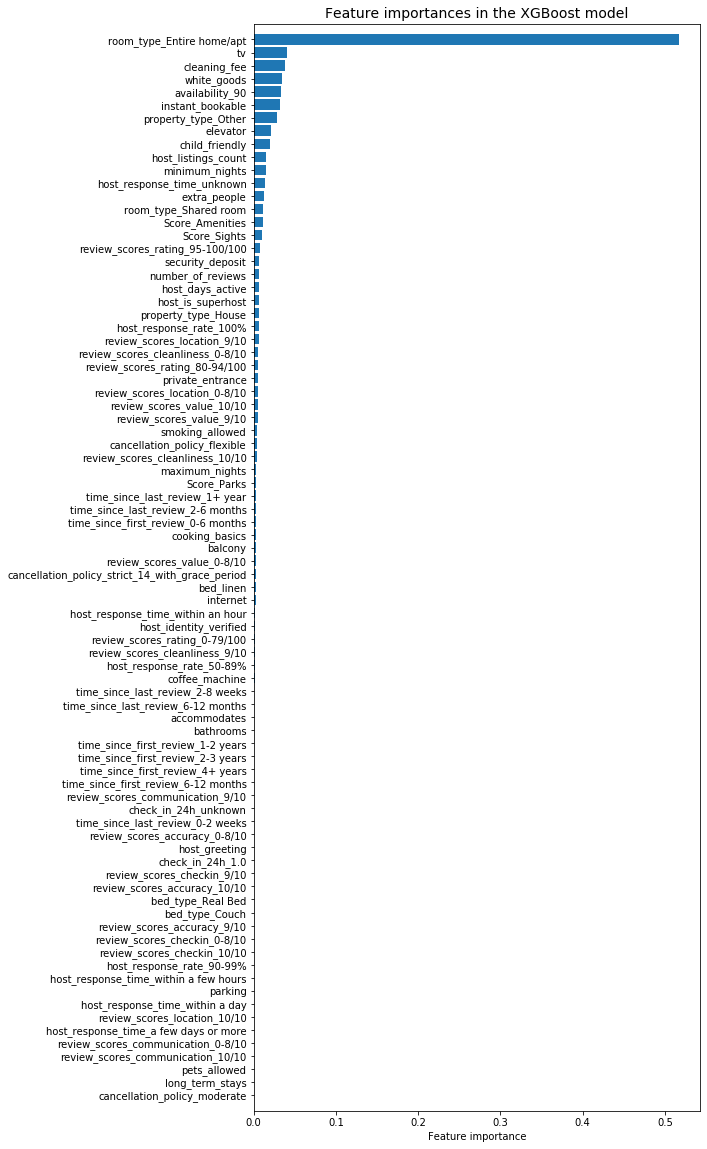

In [45]:
xgb0 = xgb.XGBRegressor()
modelfit(xgb0, df, useTrainCV=False)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:34:41] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training MSE: 0.2045
Validation MSE: 0.1952

Training r2: 0.488
Validation r2: 0.4614
                                                   weight
bed_type_Real Bed                                0.000000
review_scores_communication_0-8/10               0.000000
parking                                          0.000000
host_greeting                                    0.000000
review_scores_checkin_9/10                       0.000000
pets_allowed                                     0.000000
review_scores_checkin_10/10                      0.000000
review_scores_rating_0-79/100                    0.000000
review_scores_checkin_0-8/10                     0.000000
host_response_time_unknown                       0.000000
host_response_time_within a few hours            0.000000
host_response_time_within an hour          

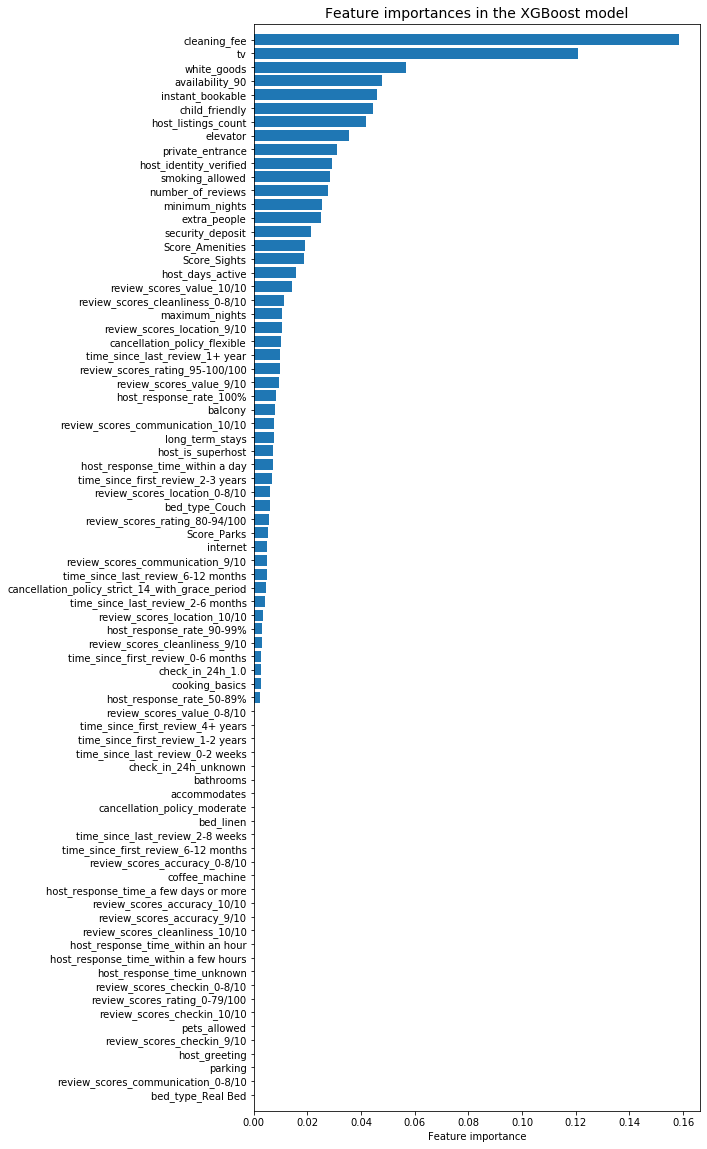

In [142]:
###################################untuned model with constant size#################################################
df_4 = df
df_4['accommodates'] = 1
df_4['bathrooms'] = 1
# drop property and room type as we have size now
df_4.drop(list(df_4.filter(regex = 'room_')), axis = 1, inplace = True)
df_4.drop(list(df_4.filter(regex = 'property_')), axis = 1, inplace = True)
modelfit(xgb0, df_4, useTrainCV=False)

#### Create a plain random forest for the Dataset

In [9]:
# Random forest to compare

regr = RandomForestRegressor()

regr.fit(X_train, y_train)


training_preds_xgb_reg = regr.predict(X_train)
val_preds_xgb_reg = regr.predict(X_test)


print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


/anaconda3/envs/AirBnB/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Training MSE: 0.0294
Validation MSE: 0.1557

Training r2: 0.9264
Validation r2: 0.5703


## Comaprison between Random Forest and XGBoost


#### untuned XGBoost:

Training MSE: 0.1041
Validation MSE: 0.1315

Training r2: 0.7395
Validation r2: 0.6371

#### Random Forest

Training MSE: 0.0294
Validation MSE: 0.1557

Training r2: 0.9264
Validation r2: 0.5703


As you can see the RMSE and r2 values are better in the Random Forest. This is not that suprising because a Random Forest tends to overfit to the training data. If we compare the test values we can see that the XGBoost model does a better job at predicting the data. Since we want a model which generalizes well to unseen data we chose the XGBoost model in the following project

## Some More Datapreprocessing

Ok, so the the 3 most important features are basically proxy-variables for the size of an airbnb. We will play around with this for this a little bit. First lets see if we can manage to combine those variables and second lets see what happens if we handle the size of an airbnb as a constant variable. In the following we will create a seperate dataset in which we will use the size of an airbnb in m2 as the only variable describing the size of an airbnb. Afterwards we will hypertune a model to both datasets and see what happens if we keep the size of an airbnb constant.

#### Note: 
This Part actually belongs of the data-preprocessing. But we put it here because we only came up with this idea after we saw the results of the feature-importance. Therefore we think the workflow is more comprehensible if this part of the data-preprocessing is put here.

If you remember, the column square_feet was heavily filled with null values, and therefore we dropped it in the previous section. But maybe there is another way around it. 
The description attribute we dropped in the previous notebook contains the size in sqm for some of the listings. 

To get the description we need to load the original raw dataset again and merge it with our cleaned version

In [47]:
df_raw = pd.read_csv(r'./berlin-airbnb-data/listings_summary.csv')

# we need to reload the cleaned dataset because we dropped the id column above
df_cleaned = pd.read_csv(r'./Data_Model/listings_model.csv')

In [48]:
# get only relevant data
df_for_merge = df_raw[['description','bedrooms','guests_included', 'id']]

#merge both dfs on id
merged_df =  pd.merge(df_for_merge, df_cleaned, on='id')

merged_df.description.isna().sum()


202

The description column seems to be rich in content. Let's extract all:

- double-digit or three-digit numbers
- that are followed by one of the two characters "s" or "m" (covering "sqm", "square meters", "m2" etc.) 
- and may or may not be connected by white space.

Single- or more than three-digit numbers for accommodation sizes are quite unlikely.


Note: This was used by [Britta Bettendorf](https://www.kaggle.com/brittabettendorf/predicting-prices-xgboost-feature-engineering) we just adopted it for our approach. If you are interessted in a more detailed approach we suggest checking out her work.

In [49]:
# extract numbers 
merged_df['size'] = merged_df['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
merged_df['size'] = merged_df['size'].str.replace("\D", "")

# change datatype of size into float
merged_df['size'] = merged_df['size'].astype(float)

print('NaNs in size_column absolute:     ', merged_df['size'].isna().sum())
print('NaNs in size_column in percentage:', round(merged_df['size'].isna().sum()/len(df_raw),3), '%')

NaNs in size_column absolute:      11746
NaNs in size_column in percentage: 0.521 %


In [50]:
merged_df[['description', 'size']].head(10)

,description,size
0,Great location! 30 of 75 sq meters. This wood...,75.0
1,In the summertime we are spending most of our ...,25.0
2,This beautiful first floor apartment is situa...,68.0
3,First of all: I prefer short-notice bookings. ...,26.0
4,Cozy and large room in the beautiful district ...,20.0
5,4 bedroom with very large windows and outstand...,780.0
6,The apartment is located on the upper second f...,NaN
7,Hello future guests! We want to rent our cute ...,55.0
8,Light and sunny 2-Room-turn of the century-fla...,80.0
9,The 25 sqm room is located in the heart of Ber...,25.0


This actually doesn't look bad at all. There are some mistakes in the size we constructed from the description but overall the result looks good. 

But we are still missing data for nearly half of our original dataset. We can't simply drop all rows with missing values since this would be to much of the original dataset, but we can use regression to predict the missing values!

In [51]:
# drop description column again
merged_df.drop(['description'], axis=1, inplace=True)

In [52]:
# filter out sub_df to select the attributes we will use to predict the sice
sub_df = merged_df[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 
                 'size']]




In [53]:
# check for nans
sub_df.isna().sum()

accommodates            0
bathrooms               0
bedrooms               18
price                   0
cleaning_fee            0
security_deposit        0
extra_people            0
guests_included         0
size                11746
dtype: int64

In [54]:
# Missing values will be replaced with the median (to avoid strange fractions)

for col in ['bedrooms']:
    sub_df[col].fillna(sub_df[col].median(), inplace=True)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [55]:
sub_df.isna().sum()

accommodates            0
bathrooms               0
bedrooms                0
price                   0
cleaning_fee            0
security_deposit        0
extra_people            0
guests_included         0
size                11746
dtype: int64

In [56]:
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

# define X
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

In [57]:
#diff = 11746 - 10731

#drop_indices = np.random.choice(test_data.index, diff, replace=False)
#test_data = test_data.drop(drop_indices)

In [58]:
print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (10731, 9)
Shape of Test Data:     (11746, 9)

Shape of X_train: (10731, 8)
Shape of X_test: (11746, 8)

Shape of y_train: (10731,)


In [59]:
# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [60]:
# making predictions
y_test = linreg.predict(X_test)

In [61]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']
print(y_test.shape)
y_test.head()

(11746, 1)


,size
0,64.020629
1,93.813971
2,77.764204
3,87.191190
4,64.562651


In [62]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)
y_test.head()

,size
prelim,
6,64.020629
11,93.813971
12,77.764204
13,87.191190
19,64.562651


In [63]:
new_test_data = pd.concat([X_test, y_test], axis=1)

In [64]:
print(new_test_data.shape)
new_test_data.head()

(11746, 9)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,size
6,0.693147,0.0,0.0,4.248495,-4.605170,6.214608,-4.605170,1,64.020629
11,1.386294,0.0,2.0,4.859812,3.891820,6.214608,3.178054,2,93.813971
12,1.386294,0.0,1.0,4.248495,3.688879,6.214608,2.890372,2,77.764204
13,1.386294,0.0,2.0,4.584967,3.912023,5.703782,3.218876,2,87.191190
19,0.693147,0.0,0.0,4.248495,-4.605170,7.414573,-4.605170,1,64.562651


In [65]:
new_test_data['size'].isna().sum()

0

In [66]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head()

(22477, 9)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,size
6,0.693147,0.0,0.0,4.248495,-4.605170,6.214608,-4.605170,1,64.020629
11,1.386294,0.0,2.0,4.859812,3.891820,6.214608,3.178054,2,93.813971
12,1.386294,0.0,1.0,4.248495,3.688879,6.214608,2.890372,2,77.764204
13,1.386294,0.0,2.0,4.584967,3.912023,5.703782,3.218876,2,87.191190
19,0.693147,0.0,0.0,4.248495,-4.605170,7.414573,-4.605170,1,64.562651


In [67]:
sub_df_new['size'].isna().sum()

0

In [68]:
# prepare the multiple columns before concatening
df_cleaned.drop(['accommodates', 'bathrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people'], 
            axis=1, inplace=True)

In [69]:
sub_df_new.drop(['guests_included', 'bedrooms'], axis=1, inplace=True)

In [70]:
df_size  = pd.concat([sub_df_new, df_cleaned], axis=1)

In [71]:
print(df_size.shape)

df_size.head(2)

(22477, 85)


,accommodates,bathrooms,price,cleaning_fee,security_deposit,extra_people,size,id,host_is_superhost,host_listings_count,...,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months,Score_Amenities,Score_Sights,Score_Parks
0,1.098612,0.0,4.094345,3.401197,5.298317,3.332205,75.0,2015,1.0,1.386294,...,0,0,0,0,0,0,0,2.011,10.177,3.038
1,0.693147,0.0,2.833213,-4.605170,-4.605170,-4.605170,25.0,2695,0.0,0.000000,...,0,0,0,0,0,0,0,3.212,14.514,4.442


In [72]:
# drop outliers
df_size.drop(df_size[ (df_size['size'] == 0.) | (df_size['size'] > 300.) ].index, axis=0, inplace=True)
df_size.drop(df_size[ (df_size['size'] == 0.) | (df_size['size'] > 300.) ].index, axis=0, inplace=True)


# drop property and room type as we have size now
df_size.drop(list(df.filter(regex = 'room_')), axis = 1, inplace = True)
df_size.drop(list(df.filter(regex = 'property_')), axis = 1, inplace = True)

In [73]:
numerical_columns = ['size']
# log transformation for the new size attribzte

for col in numerical_columns:
    df_size[col] = df_size[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df_size[col] = np.log(df_size[col])

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [74]:
print("The new dataset has {} rows and {} columns - after being engineered.".format(*df_size.shape))

The new dataset has 22038 rows and 81 columns - after being engineered.


In [75]:
# save df to disc
df_size.to_csv(r'./Data_Model/Berlin_listings_size.csv')

### Create untuned Model for the new Size-Dataset

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:19] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training MSE: 0.1285
Validation MSE: 0.1334

Training r2: 0.6713
Validation r2: 0.6564
                                                   weight
bed_type_Real Bed                                0.000000
review_scores_communication_9/10                 0.000000
review_scores_communication_10/10                0.000000
host_response_time_a few days or more            0.000000
host_response_time_unknown                       0.000000
host_response_time_within a day                  0.000000
host_response_time_within a few hours            0.000000
host_response_time_within an hour                0.000000
host_response_rate_50-89%                        0.000000
parking                                          0.000000
host_response_rate_90-99%                        0.000000
review_scores_communication_0-8/10        

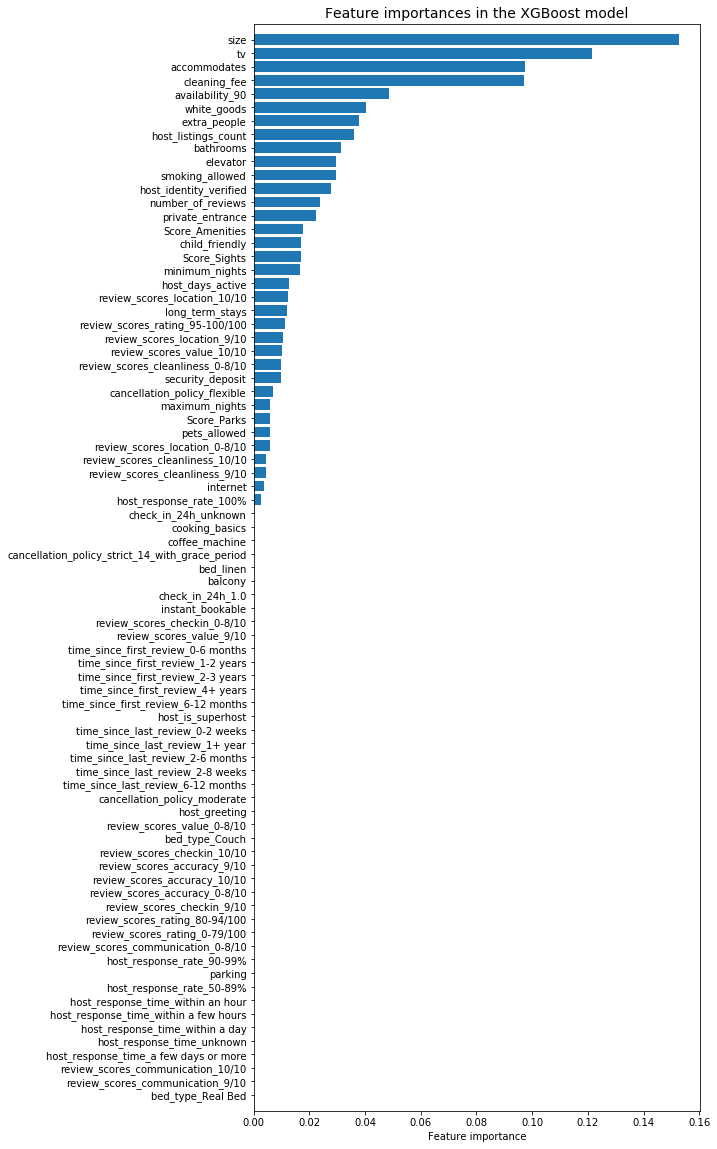

In [78]:
# untuned SIZE 
modelfit(xgb0, df_size, useTrainCV=False)

## Start Tuning

Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.

## Default Dataset
#### learning rate 0.2
Training MSE: 0.0924
Validation MSE: 0.1329

Training r2: 0.7688
Validation r2: 0.6334
    
#### learning rate 0.15
Training MSE: 0.0815
Validation MSE: 0.1309

Training r2: 0.796
Validation r2: 0.6388

#### learning rate 0.1

Training MSE: 0.0883
Validation MSE: 0.1289

Training r2: 0.7789
Validation r2: 0.6442

#### learning rate 0.05

Training MSE: 0.0806
Validation MSE: 0.127

Training r2: 0.7983
Validation r2: 0.6495


=> a learning rate of 0.05 seems to give us the best output so lets start hypertuning

    
#### tuned
Training MSE: 0.0928
Validation MSE: 0.131

Training r2: 0.7676
Validation r2: 0.6384


## Size Dataset

For the size Dataset a learning rate of 0.03 yields the best results (See below for the test)

#### tuned

Training MSE: 0.0245
Validation MSE: 0.0986

Training r2: 0.9374
Validation r2: 0.746

## Hypertuning:

To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [4]:
# sadly this is to computing intensive and takes ages. i interrupted it after 10 hours
# Note this would be the proper way of hypertuning the model but both of this options are to computing intensive.
# Therefore we needed to do it seperatly

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth':[range(3,10,2)],
              'min_child_weight':[range(1,6,2)],
              'subsample':[i/10.0 for i in range(6,10)],
              'colsample_bytree':[i/10.0 for i in range(6,10)],
              'gamma':[i/10.0 for i in range(0,5)],
              'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}


# therefore we use those
param_grid_1 = {
              'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'min_child_weight': [0, 2, 4],
              'subsample' : [0.6, 0.7, 0.8],
              'reg_alpha' : [0.04, 0.05, 0.06],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]
}

In [6]:
################################## to computing intensive for our computers#####################################
booster = xgb.XGBRegressor()

booster_grid_search = GridSearchCV(booster, param_grid_1, cv=5, n_jobs=4)

# we need to redo this since X and y were used in the regression above
# Training and testing data
X = df.drop('price', axis=1)

# Target
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

booster_grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
booster_grid_search.cv_results_, booster_grid_search.best_params_, booster_grid_search.best_score_


In [ ]:
################################## to computing intensive for our computers#####################################

# now for the new dataset

booster = xgb.XGBRegressor()

booster_grid_search = GridSearchCV(booster, param_grid_1, cv=5, n_jobs=4)

# we need to redo this since X and y were used in the regression above
# Training and testing data
X = df_size.drop('price', axis=1)

# Target
y = df_size.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

booster_grid_search_2.fit(X_train, y_train)

In [ ]:
booster_grid_search_2.cv_results_, booster_grid_search_2.best_params_, booster_grid_search_2.best_score_

### Default Regressor

Since our computers can't handle the proper way of hypertuning the xgboost model we have to do it seperatly.
So lets start set up a default Regressor

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:07:56] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:56] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:57] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:57] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:57] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,


/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Training MSE: 0.0969
Validation MSE: 0.1477

Training r2: 0.7576
Validation r2: 0.5926


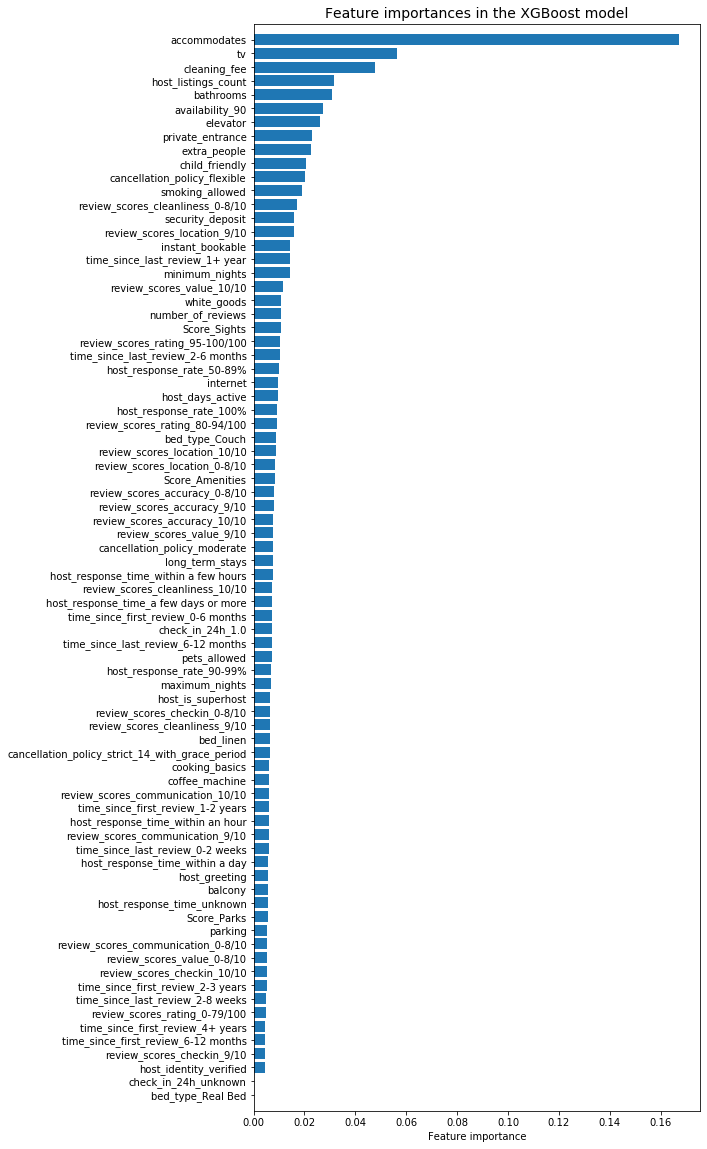

In [180]:

xgb1 = xgb.XGBRegressor(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    silent=False
)

modelfit(xgb1, df)

### Hypertuning Default Dataset

Here is the Hypertuning for the default datset. We splittet the parameters to make it processable for our computers

### Max Depth and Min Child Weight

In [166]:

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

df = df.sample(frac=1, random_state=0)


X = df.drop('price', axis=1)

# Target
y = df.price

# Datamatrix
data_dmatrix = xgb.DMatrix(data=X,label=y)

# Split-Data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)


gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=5,
             min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch1.fit(X_train, y_train)


/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
  

In [137]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


({'mean_fit_time': array([ 93.56818919,  96.1713613 ,  95.98838191, 133.42388582,
         110.80395956, 108.56298337, 150.36885839, 148.04472995,
         142.12508245, 193.55112572, 188.8466433 , 178.43172498]),
  'std_fit_time': array([ 0.81496704,  1.29328634,  1.08367548,  9.2583231 ,  0.48464497,
          2.11791827,  2.56915398,  1.12536283,  3.45549635,  3.34236271,
          4.7200043 , 20.8494257 ]),
  'mean_score_time': array([0.1555069 , 0.13833609, 0.1703567 , 0.21173649, 0.21848607,
         0.19808211, 0.36655269, 0.37199726, 0.35791073, 0.57592063,
         0.59619384, 0.42032099]),
  'std_score_time': array([0.02969529, 0.02712547, 0.02728628, 0.01628579, 0.03191388,
         0.02158252, 0.03430804, 0.01573007, 0.02814292, 0.05161173,
         0.05853193, 0.18207301]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False]

In [133]:
gsearch1.cv_results_['params'][gsearch1.best_index_]


{'max_depth': 7, 'min_child_weight': 3}

In [138]:
param_test4 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}


gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=5,
             min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch4.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
  

In [139]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_


({'mean_fit_time': array([ 93.30737658,  91.45020747,  89.66110024, 128.43457513,
         127.14937577, 128.53591504, 186.61053085, 182.6421236 ,
         163.1959672 , 221.70748916, 214.46012783, 186.59931946]),
  'std_fit_time': array([ 1.44041565,  1.23459471,  2.67021354,  2.98053048,  2.38845051,
          5.51884794, 13.27932885,  2.84644117,  6.91133468,  4.23630066,
          2.20666371, 22.10164518]),
  'mean_score_time': array([0.13494139, 0.14510055, 0.11822176, 0.22521634, 0.20903168,
         0.19963136, 0.38821211, 0.41919985, 0.40331721, 0.6491611 ,
         0.59946866, 0.41091232]),
  'std_score_time': array([0.02292332, 0.02931649, 0.01590454, 0.03163446, 0.01631388,
         0.02739885, 0.02131934, 0.04289056, 0.01650492, 0.07379499,
         0.02058064, 0.18511094]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False]

In [ ]:
gsearch4.cv_results_['params'][gsearch4.best_index_]


In [142]:
param_test2 = {
 'max_depth':[4,5,6,7],
 'min_child_weight':[0,1,2,3]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=5,
             min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch2.fit(X_train, y_train)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'min_child_weight': [0, 1, 2, 3]},
       

In [143]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_


({'mean_fit_time': array([116.10074883, 119.10520544, 115.80741735, 115.22320342,
         133.07054482, 136.39849753, 134.08847694, 127.3322444 ,
         154.38628035, 154.20829268, 154.61044636, 152.04349451,
         148.32644596, 148.7350656 , 161.06856632, 180.9150784 ]),
  'std_fit_time': array([ 2.7712047 ,  3.94787724,  1.14890588,  0.70215853,  1.88081538,
          1.15676726,  0.79158457,  2.49336609,  1.02805733,  0.58154757,
          1.23304721,  0.98870126,  0.15298115,  0.26899953, 11.50312201,
          7.47789719]),
  'mean_score_time': array([0.16186085, 0.15055685, 0.13259778, 0.16635361, 0.16271653,
         0.20088081, 0.1994935 , 0.23390484, 0.28650508, 0.3222672 ,
         0.33142567, 0.302876  , 0.37809243, 0.3768466 , 0.42800832,
         0.26495867]),
  'std_score_time': array([0.03587023, 0.00667727, 0.01118159, 0.03820935, 0.04996575,
         0.02618042, 0.01862251, 0.0486411 , 0.04063915, 0.03940341,
         0.02703691, 0.02836178, 0.0201367 , 0.033847 

In [144]:
gsearch2.cv_results_['params'][gsearch2.best_index_]


{'max_depth': 5, 'min_child_weight': 0}

=> Max_depth = 5 and min_child_weight = 0

### Gamma

In [146]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=5,
             min_child_weight=0, gamma=0, subsample=0.8, colsample_bytree=0.8,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch3.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=0, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_

In [147]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_


({'mean_fit_time': array([136.5070899 , 134.42255855, 135.10745869, 140.12725735,
         115.30406003]),
  'std_fit_time': array([ 1.20908294,  0.80646167,  0.63116154,  3.27128042, 40.57984165]),
  'mean_score_time': array([0.23766475, 0.23490505, 0.23310304, 0.19955735, 0.15693603]),
  'std_score_time': array([0.02660914, 0.04169532, 0.03724483, 0.02991447, 0.05730893]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.6381346 , 0.63851932, 0.63760689, 0.63506157, 0.63685474]),
  'split1_test_score': array([0.65513333, 0.65663699, 0.65431468, 0.65677538, 0.6558377 ]),
  'split2_test_score': array([0.6658335 , 0.66288402, 0.66206484, 0.66237297, 0.66621736]),
  'split3_test_score': array([0.63600798, 0.63516968, 0.63669601, 0

=> best gamma = 0.4

Lets put the parameters into the xgboost model and check if we made improvements

In [148]:
xgb2 = xgb.XGBRegressor(
    learning_rate=0.05,
    n_estimators=588,
    max_depth=5,
    min_child_weight=0,
    gamma=0.4,
    subsample=0.8,
    colsample_bytree=0.8,
    silent=False,
    scale_pos_weight=1,
    objective= 'reg:squarederror',
    seed=27
)

modelfit(xgb2, df)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.4,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=0, missing=None, n_estimators=677,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=27, silent=False, subsample=0.8, verbosity=1)

Training MSE: 0.0798
Validation MSE: 0.1334

Training r2: 0.7959
Validation r2: 0.6628


### Subsample and Colsample Bytree

In [149]:
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=5,
             min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch5.fit(X_train, y_train)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0.4,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=0, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0

In [150]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([109.83360691, 112.09794412, 112.39302707, 111.90861511,
         123.9483727 , 120.80660644, 117.90805168, 125.75590978,
         129.30257416, 130.85327215, 128.34765673, 133.06311502,
         146.98758755, 149.74979277, 143.02906632, 148.27985296]),
  'std_fit_time': array([0.38382965, 1.87107151, 1.75015191, 0.66572503, 1.53000182,
         0.52989901, 1.61848118, 4.76662361, 0.2855669 , 0.71949842,
         1.52215916, 3.44789418, 2.07809043, 2.6783128 , 2.72347203,
         4.00166009]),
  'mean_score_time': array([0.18951426, 0.22356362, 0.18525724, 0.18837981, 0.22223454,
         0.18203855, 0.23430057, 0.20567045, 0.19106665, 0.21234345,
         0.20364709, 0.2171442 , 0.19668779, 0.19032426, 0.20439453,
         0.14981437]),
  'std_score_time': array([0.04773873, 0.03979371, 0.0251102 , 0.01887651, 0.05289685,
         0.01084041, 0.02378229, 0.03284833, 0.01848224, 0.04180033,
         0.02836203, 0.0316567 , 0.02491292, 0.01708464, 0.02285584,
 

Here, we found 0.8 as the optimum value for  subsample and 0.6 for colsample_bytree. Now we should try values in 0.05 interval around these.

In [151]:
param_test6 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}

gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=5,
             min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch6.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0.4,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=0, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.55, 0.6, 0.65],
                         'subsample': [0.75, 0.8, 0.8

In [152]:
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([ 94.98120122,  91.74391842,  91.66222825,  95.03262219,
          95.75531759,  96.3296452 , 109.81112919, 114.43183413,
          97.56696229]),
  'std_fit_time': array([ 1.99255025,  0.45301802,  0.53366666,  0.42714877,  0.3102295 ,
          0.83503909,  7.37609853,  1.00576062, 31.73516029]),
  'mean_score_time': array([0.17313352, 0.18302135, 0.18086605, 0.18797035, 0.17589517,
         0.19693093, 0.21329832, 0.18016582, 0.13707104]),
  'std_score_time': array([0.00723857, 0.02129281, 0.02811878, 0.0170659 , 0.02517273,
         0.02140252, 0.015732  , 0.02087324, 0.04773283]),
  'param_colsample_bytree': masked_array(data=[0.55, 0.55, 0.55, 0.6, 0.6, 0.6, 0.65, 0.65, 0.65],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[False, Fal

=> colsample_bytree= 0.55, subsample=0.8

### Reg Alpha
Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’

In [153]:
param_test7 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch7 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=5,
             min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.55,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test7, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch7.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.55, gamma=0.4,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=0, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             pre_dispatch='2*n_jobs', refit=True,

In [154]:
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([114.64231372, 133.65326319, 106.87327003, 105.27970552,
          74.4755199 ]),
  'std_fit_time': array([17.30358665, 19.28056133,  2.61547365,  0.68002135, 24.43266704]),
  'mean_score_time': array([0.19961138, 0.22994184, 0.19389429, 0.20526347, 0.11116648]),
  'std_score_time': array([0.03522717, 0.02960669, 0.02798419, 0.00946859, 0.04608964]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.63899709, 0.64025532, 0.63697877, 0.63917236, 0.55787548]),
  'split1_test_score': array([0.65389056, 0.65455971, 0.65339171, 0.65182908, 0.55209788]),
  'split2_test_score': array([0.6692035 , 0.67086385, 0.67106513, 0.67095203, 0.56966476]),
  'split3_test_score': array([0.64062667,

In [157]:
param_test8 = {
 'reg_alpha':[0.05, 0.06, 0.07, 0.08]
}

gsearch8 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=5,
             min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.55,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test8, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch8.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.55, gamma=0.4,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=0, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'reg_alpha': [0.05, 0.06, 0.07, 0.08]},
             pre_dispatch='2*n_jobs', refit=True, r

In [158]:
gsearch8.cv_results_, gsearch8.best_params_, gsearch8.best_score_

({'mean_fit_time': array([105.26738319, 105.69672685, 109.09288497, 109.9000288 ]),
  'std_fit_time': array([0.52529681, 0.49410643, 2.59632046, 0.86700083]),
  'mean_score_time': array([0.22400684, 0.18153148, 0.19457555, 0.14553499]),
  'std_score_time': array([0.03557198, 0.03082953, 0.03278119, 0.05990685]),
  'param_reg_alpha': masked_array(data=[0.05, 0.06, 0.07, 0.08],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0.05},
   {'reg_alpha': 0.06},
   {'reg_alpha': 0.07},
   {'reg_alpha': 0.08}],
  'split0_test_score': array([0.64218166, 0.63796606, 0.63778884, 0.63997408]),
  'split1_test_score': array([0.65349759, 0.65352035, 0.65427571, 0.6537734 ]),
  'split2_test_score': array([0.67070734, 0.67009158, 0.66948538, 0.67162081]),
  'split3_test_score': array([0.64015519, 0.6386245 , 0.63855056, 0.63923233]),
  'split4_test_score': array([0.6570125 , 0.65618455, 0.65711628, 0.65729935]),
  'mean_te

=> regalpha 0.05

### Now put everything back into the original Model and test for improvements

In [159]:
xgb3 = xgb.XGBRegressor(
    learning_rate=0.05,
    n_estimators=588,
    max_depth=5,
    min_child_weight=0,
    gamma=0.4,
    subsample=0.8,
    colsample_bytree=0.55,
    silent=False,
    scale_pos_weight=1,
    reg_alpha=0.05,
    objective= 'reg:squarederror',
    seed=27
)

modelfit(xgb3, df)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.55, gamma=0.4,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=0, missing=None, n_estimators=821,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
             seed=27, silent=False, subsample=0.8, verbosity=1)

Training MSE: 0.0791
Validation MSE: 0.1333

Training r2: 0.7977
Validation r2: 0.6629


### Now lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

In [161]:
xgb4 = xgb.XGBRegressor(
    learning_rate=0.005,
    n_estimators=5000,
    max_depth=5,
    min_child_weight=0,
    gamma=0.4,
    subsample=0.8,
    colsample_bytree=0.55,
    silent=False,
    scale_pos_weight=1,
    reg_alpha=0.05,
    objective= 'reg:squarederror',
    seed=27
)

modelfit(xgb4, df)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.55, gamma=0.4,
             importance_type='gain', learning_rate=0.005, max_delta_step=0,
             max_depth=5, min_child_weight=0, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
             seed=27, silent=False, subsample=0.8, verbosity=1)

Training MSE: 0.1291
Validation MSE: 0.1434

Training r2: 0.6701
Validation r2: 0.6375


In [162]:
xgb4 = xgb.XGBRegressor(
    learning_rate=0.025,
    n_estimators=5000,
    max_depth=5,
    min_child_weight=0,
    gamma=0.4,
    subsample=0.8,
    colsample_bytree=0.55,
    silent=False,
    scale_pos_weight=1,
    reg_alpha=0.05,
    objective= 'reg:squarederror',
    seed=27
)

modelfit(xgb4, df)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.55, gamma=0.4,
             importance_type='gain', learning_rate=0.025, max_delta_step=0,
             max_depth=5, min_child_weight=0, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
             seed=27, silent=False, subsample=0.8, verbosity=1)

Training MSE: 0.0908
Validation MSE: 0.1325

Training r2: 0.7679
Validation r2: 0.665


### => Best parameters

In [163]:
xgb4 = xgb.XGBRegressor(
    learning_rate=0.03,
    n_estimators=5000,
    max_depth=5,
    min_child_weight=0,
    gamma=0.4,
    subsample=0.8,
    colsample_bytree=0.55,
    silent=False,
    scale_pos_weight=1,
    reg_alpha=0.05,
    objective= 'reg:squarederror',
    seed=27
)

modelfit(xgb4, df)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.55, gamma=0.4,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=0, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
             seed=27, silent=False, subsample=0.8, verbosity=1)

Training MSE: 0.0866
Validation MSE: 0.1324

Training r2: 0.7786
Validation r2: 0.6654


In [164]:
xgb5 = xgb.XGBRegressor(
    learning_rate=0.035,
    n_estimators=5000,
    max_depth=5,
    min_child_weight=0,
    gamma=0.4,
    subsample=0.8,
    colsample_bytree=0.55,
    silent=False,
    scale_pos_weight=1,
    reg_alpha=0.05,
    objective= 'reg:squarederror',
    seed=27
)

modelfit(xgb5, df)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.55, gamma=0.4,
             importance_type='gain', learning_rate=0.035, max_delta_step=0,
             max_depth=5, min_child_weight=0, missing=None, n_estimators=865,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
             seed=27, silent=False, subsample=0.8, verbosity=1)

Training MSE: 0.0865
Validation MSE: 0.1326

Training r2: 0.7788
Validation r2: 0.6647


In [184]:
xgb6 = xgb.XGBRegressor(
    learning_rate=0.04,
    n_estimators=5000,
    max_depth=5,
    min_child_weight=0,
    gamma=0.4,
    subsample=0.8,
    colsample_bytree=0.55,
    silent=False,
    scale_pos_weight=1,
    reg_alpha=0.05,
    objective= 'reg:squarederror',
    seed=27
)

modelfit(xgb6, df)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.55, gamma=0.4,
             importance_type='gain', learning_rate=0.04, max_delta_step=0,
             max_depth=5, min_child_weight=0, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
             seed=27, silent=False, subsample=0.8, verbosity=1)


/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Training MSE: 0.0793
Validation MSE: 0.1402

Training r2: 0.7992
Validation r2: 0.6323


## Hypertuning Size Dataset

In [81]:
##load size Dataset again and set id as index
df_size = pd.read_csv('Berlin_listings_size.csv')
df_size.reset_index(level=0, inplace=True)
df_size.set_index('id',inplace=True)
df_size.drop(columns=['index', 'Unnamed: 0'], inplace=True)

df_size

,accommodates,bathrooms,price,cleaning_fee,security_deposit,extra_people,size,host_is_superhost,host_listings_count,host_identity_verified,...,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months,Score_Amenities,Score_Sights,Score_Parks
id,,,,,,,,,,,,,,,,,,,,,
2015,1.098612,0.0,4.094345,3.401197,5.298317,3.332205,4.317488,1.0,1.386294,1.0,...,0,0,0,0,0,0,0,2.011,10.177,3.038
2695,0.693147,0.0,2.833213,-4.605170,-4.605170,-4.605170,3.218876,0.0,0.000000,1.0,...,0,0,0,0,0,0,0,3.212,14.514,4.442
3176,1.386294,0.0,4.499810,3.912023,5.298317,2.995732,4.219508,0.0,0.000000,1.0,...,1,0,0,1,0,0,0,0.626,11.891,2.124
3309,0.693147,0.0,3.258097,3.401197,5.521461,2.890372,3.258097,0.0,0.000000,1.0,...,1,0,0,0,0,0,0,2.454,10.662,3.140
7071,0.693147,0.0,3.737670,-4.605170,-4.605170,3.178054,2.995732,1.0,0.000000,1.0,...,1,0,0,0,0,0,0,0.993,10.348,0.281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29856708,0.693147,0.0,4.094345,-4.605170,-4.605170,-4.605170,4.044518,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1.656,9.693,0.256
29857108,1.791759,0.0,2.995732,-4.605170,-4.605170,2.302585,3.750771,0.0,1.791759,0.0,...,0,0,0,0,0,0,0,0.848,11.874,1.502
29864272,0.693147,0.0,4.442651,-4.605170,-4.605170,-4.605170,4.153707,0.0,1.098612,1.0,...,0,0,0,0,0,0,0,1.389,8.752,2.990


### Max Depth and Min Child Weight

In [6]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

df_size = df_size.sample(frac=1, random_state=0)


X = df_size.drop('price', axis=1)

# Target
y = df_size.price

# Datamatrix
data_dmatrix = xgb.DMatrix(data=X,label=y)

# Split-Data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)


gsearch_size_1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=5,
             min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch_size_1.fit(X_train, y_train)


/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
  

In [7]:
gsearch_size_1.best_params_, gsearch_size_1.best_score_


({'max_depth': 7, 'min_child_weight': 3}, -0.1083866342441287)

In [8]:
param_test2 = {
 'max_depth':[6,7,8],
 'min_child_weight':[2,3,4]
}

gsearch_size_3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=5,
             min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch_size_3.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'max_depth': [6, 7, 8], 'min_child_weight': [2, 3, 4]},
             pre_dispatch='2*n_jobs', 

In [9]:
gsearch_size_3.best_params_

{'max_depth': 7, 'min_child_weight': 3}

### Gamma

In [10]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch_size_4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=7,
             min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch_size_4.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=7,
                                    min_child_weight=3, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_

In [11]:
gsearch_size_4.best_params_

{'gamma': 0.0}

### Subsample and Colsample Bytree

In [21]:
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch_size_5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=7,
             min_child_weight=5, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch_size_5.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0.0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=7,
                                    min_child_weight=5, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0

In [22]:
gsearch_size_5.best_params_

{'colsample_bytree': 0.7, 'subsample': 0.8}

In [23]:
param_test6 = {
 'subsample':[i/100.0 for i in range(75,95,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}

gsearch_size_6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=7,
             min_child_weight=5, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch_size_6.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0.0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=7,
                                    min_child_weight=5, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.65, 0.7, 0.75],
                         'subsample': [0.75, 0.8, 0.8

In [24]:
gsearch_size_6.best_params_

{'colsample_bytree': 0.7, 'subsample': 0.8}

### Reg Alpha

In [26]:
param_test7 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch_size_7 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=7,
             min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.7,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test7, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch_size_7.fit(X_train, y_train)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.7, gamma=0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=7,
                                    min_child_weight=3, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             pre_dispatch='2*n_jobs', refit=True, re

In [27]:
gsearch_size_7.best_params_

{'reg_alpha': 0.01}

In [28]:
param_test8 = {
 'reg_alpha':[0.001, 0.05, 0.025]
}

gsearch_size_8 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=588, max_depth=7,
             min_child_weight=3, gamma=0.0, subsample=0.8, colsample_bytree=0.7,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
             param_grid = param_test8, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch_size_8.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.7, gamma=0.0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=7,
                                    min_child_weight=3, missing=None,
                                    n_estimators=588, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'reg_alpha': [0.001, 0.05, 0.025]},
             pre_dispatch='2*n_jobs', refit=True, return

In [29]:
gsearch_size_8.best_params_

{'reg_alpha': 0.05}

### Learning Rate

In [30]:
param_test9 = {
 'learning_rate':[0.02, 0.03, 0.04, 0.01]
}

gsearch_size_9 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=800, max_depth=7,
             min_child_weight=3, gamma=0.0, subsample=0.8, colsample_bytree=0.7,
             objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27, reg_alpha = 0.05), 
             param_grid = param_test9, scoring='neg_mean_squared_error',n_jobs=4, cv=5, refit=True)

gsearch_size_9.fit(X_train, y_train)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.7, gamma=0.0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=7,
                                    min_child_weight=3, missing=None,
                                    n_estimators=800, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0.05,
                                    reg_lambda=1, scale_pos_weight=1, seed=27,
                                    silent=None, subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'learning_rate': [0.02, 0.03, 0.04, 0.01]},
             pre_dispatch='2*n_jobs', refit=T

In [31]:
gsearch_size_9.best_params_

{'learning_rate': 0.03}

Now put all the parameters into the model and play around with the learning rate

### Final Results

#### Size Dataset

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=7, min_child_weight=3, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
             seed=27, silent=False, subsample=0.8, verbosity=1)


/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Training MSE: 0.0245
Validation MSE: 0.0986

Training r2: 0.9374
Validation r2: 0.746
                                                   weight
review_scores_checkin_10/10                      0.004535
cooking_basics                                   0.004967
time_since_first_review_2-3 years                0.005009
review_scores_accuracy_10/10                     0.005031
parking                                          0.005410
review_scores_checkin_9/10                       0.005420
time_since_first_review_6-12 months              0.005469
review_scores_value_0-8/10                       0.005733
review_scores_cleanliness_10/10                  0.005736
cancellation_policy_moderate                     0.005752
review_scores_communication_9/10                 0.005876
coffee_machine                                   0.005915
host_greeting                                    0.006073
host_response_time_within an hour                0.006125
time_since_first_review_1-2 years          

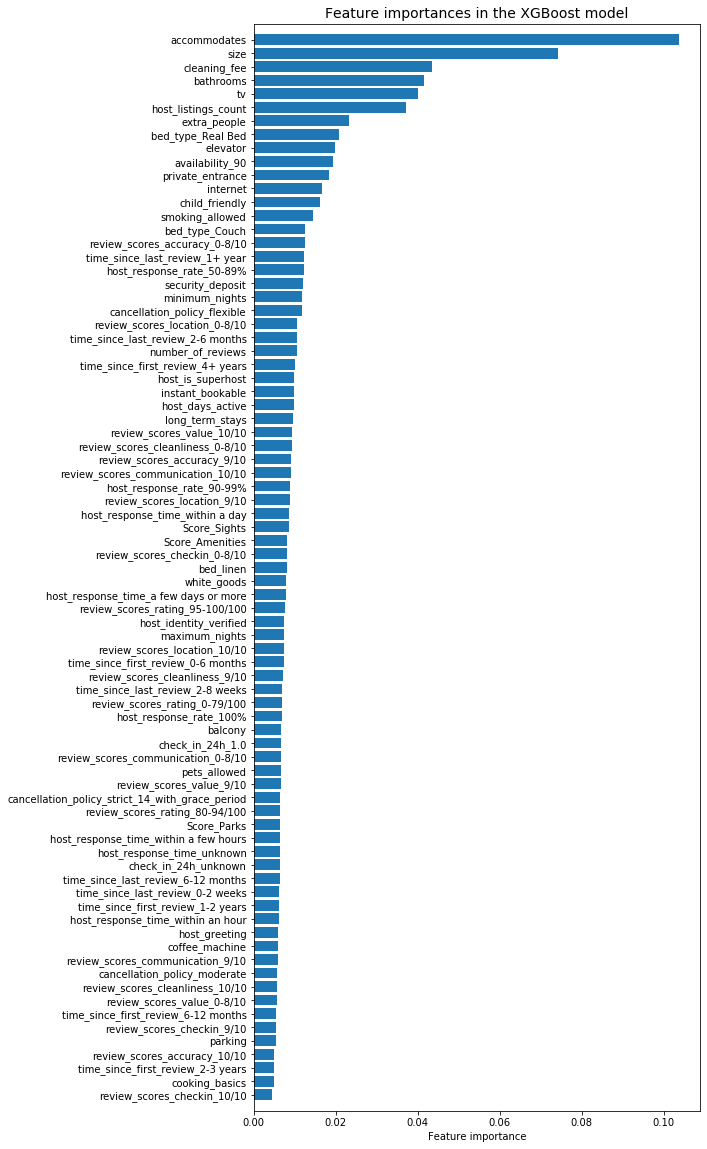

In [34]:
# Tuned Model for Size Dataset

xgb_size = xgb.XGBRegressor(
    learning_rate=0.03,
    n_estimators=5000,
    max_depth=7,
    min_child_weight=3,
    gamma=0.0,
    subsample=0.8,
    colsample_bytree=0.7,
    silent=False,
    scale_pos_weight=1,
    reg_alpha=0.05,
    objective= 'reg:squarederror',
    seed=27
)

modelfit(xgb_size, df_size, useTrainCV=True)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Training MSE: 0.0245
Validation MSE: 0.0986

Training r2: 0.9374
Validation r2: 0.746
                                                   weight
review_scores_checkin_10/10                      0.004535
cooking_basics                                   0.004967
time_since_first_review_2-3 years                0.005009
review_scores_accuracy_10/10                     0.005031
parking                                          0.005410
review_scores_checkin_9/10                       0.005420
time_since_first_review_6-12 months              0.005469
review_scores_value_0-8/10                       0.005733
review_scores_cleanliness_10/10                  0.005736
cancellation_policy_moderate                     0.005752
review_scores_communication_9/10                 0.005876
coffee_machine                                   0.005915
host_greeting                                    0.006073
host_response_time_within an hour                0.006125
time_since_first_review_1-2 years          

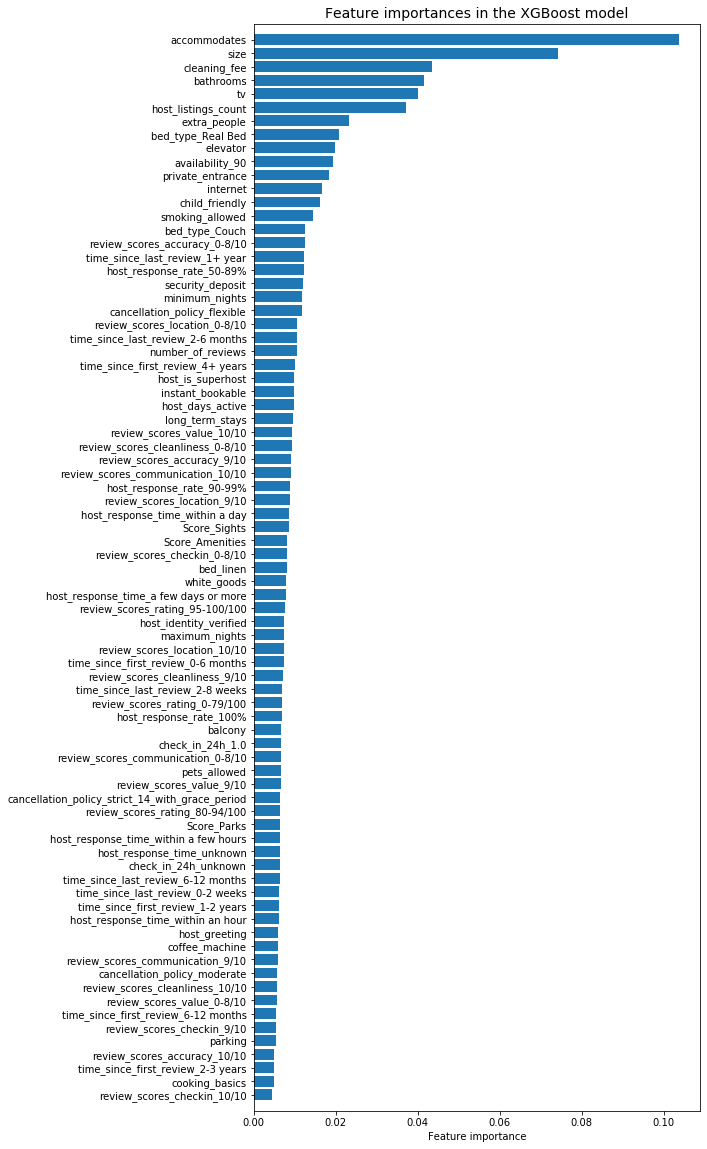

In [35]:
modelfit(xgb_size, df_size, useTrainCV=False)

OK lets play around, and keep size attributes constant

In [36]:
df_size_constant = df_size
df_size_constant['accommodates'] = 1
df_size_constant['bathrooms'] = 1
df_size_constant['size'] =1

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Training MSE: 0.0604
Validation MSE: 0.1898

Training r2: 0.8456
Validation r2: 0.5111
                                                   weight
accommodates                                     0.000000
bathrooms                                        0.000000
size                                             0.000000
host_identity_verified                           0.006319
review_scores_cleanliness_10/10                  0.006529
time_since_first_review_6-12 months              0.006540
review_scores_checkin_10/10                      0.006583
cooking_basics                                   0.006742
time_since_first_review_2-3 years                0.006808
cancellation_policy_moderate                     0.006972
review_scores_communication_10/10                0.007074
review_scores_accuracy_10/10                     0.007290
coffee_machine                                   0.007395
host_greeting                                    0.007468
review_scores_checkin_9/10                

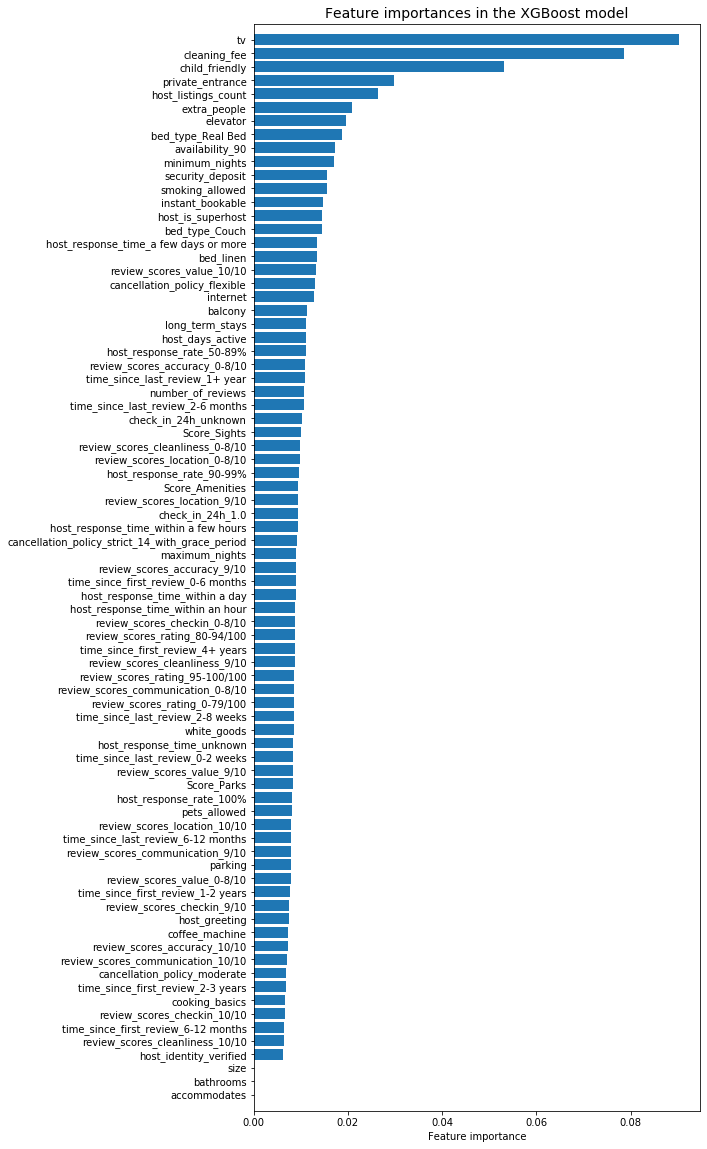

In [37]:
modelfit(xgb_size, df_size_constant, useTrainCV=False)

### Default Dataset

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.55, gamma=0.4,
             importance_type='gain', learning_rate=0.025, max_delta_step=0,
             max_depth=5, min_child_weight=0, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
             seed=27, silent=False, subsample=0.8, verbosity=1)


/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Training MSE: 0.095
Validation MSE: 0.1276

Training r2: 0.7622
Validation r2: 0.6479
                                                   weight
time_since_last_review_0-2 weeks                 0.002106
review_scores_value_0-8/10                       0.002175
time_since_first_review_6-12 months              0.002356
review_scores_checkin_9/10                       0.002361
review_scores_checkin_0-8/10                     0.002396
host_response_time_a few days or more            0.002404
time_since_last_review_6-12 months               0.002454
host_response_rate_90-99%                        0.002455
time_since_last_review_2-8 weeks                 0.002511
review_scores_communication_0-8/10               0.002542
review_scores_checkin_10/10                      0.002575
review_scores_rating_0-79/100                    0.002604
Score_Parks                                      0.002633
review_scores_cleanliness_9/10                   0.002690
time_since_first_review_1-2 years          

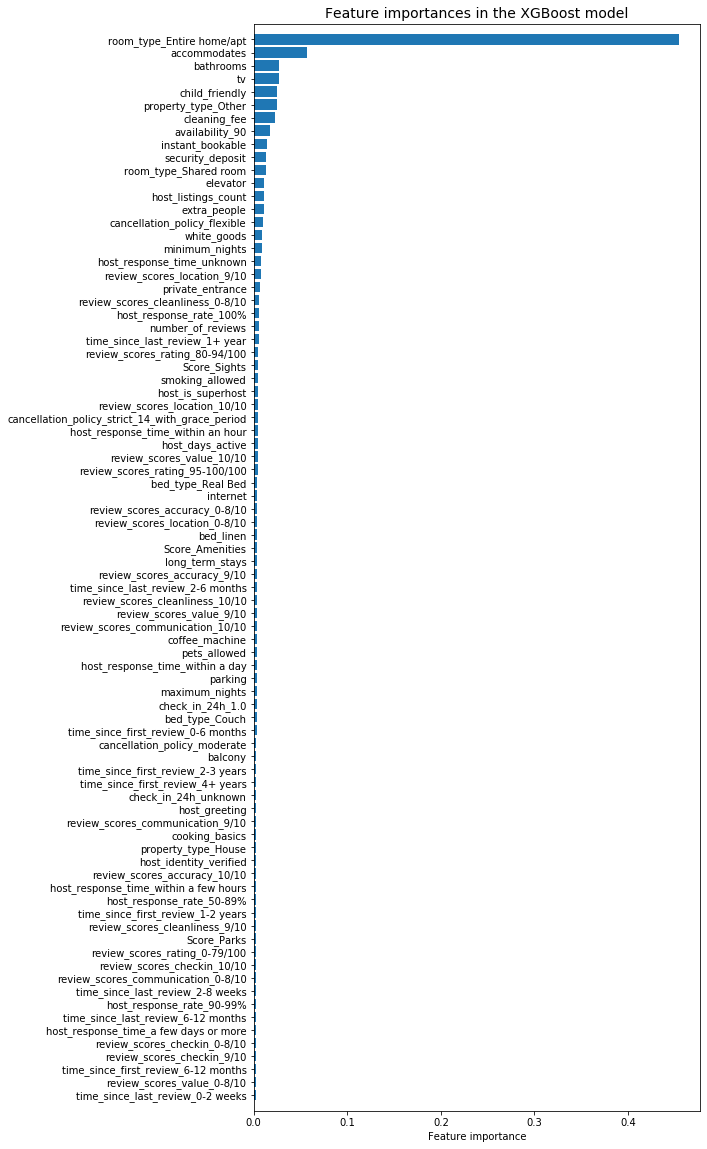

In [38]:
# Tuned Model for Default Dataset

xgb_default = xgb.XGBRegressor(
    learning_rate=0.025,
    n_estimators=5000,
    max_depth=5,
    min_child_weight=0,
    gamma=0.4,
    subsample=0.8,
    colsample_bytree=0.55,
    silent=False,
    scale_pos_weight=1,
    reg_alpha=0.05,
    objective= 'reg:squarederror',
    seed=27
)

modelfit(xgb_default, df, useTrainCV=True)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Training MSE: 0.095
Validation MSE: 0.1276

Training r2: 0.7622
Validation r2: 0.6479
                                                   weight
time_since_last_review_0-2 weeks                 0.002106
review_scores_value_0-8/10                       0.002175
time_since_first_review_6-12 months              0.002356
review_scores_checkin_9/10                       0.002361
review_scores_checkin_0-8/10                     0.002396
host_response_time_a few days or more            0.002404
time_since_last_review_6-12 months               0.002454
host_response_rate_90-99%                        0.002455
time_since_last_review_2-8 weeks                 0.002511
review_scores_communication_0-8/10               0.002542
review_scores_checkin_10/10                      0.002575
review_scores_rating_0-79/100                    0.002604
Score_Parks                                      0.002633
review_scores_cleanliness_9/10                   0.002690
time_since_first_review_1-2 years          

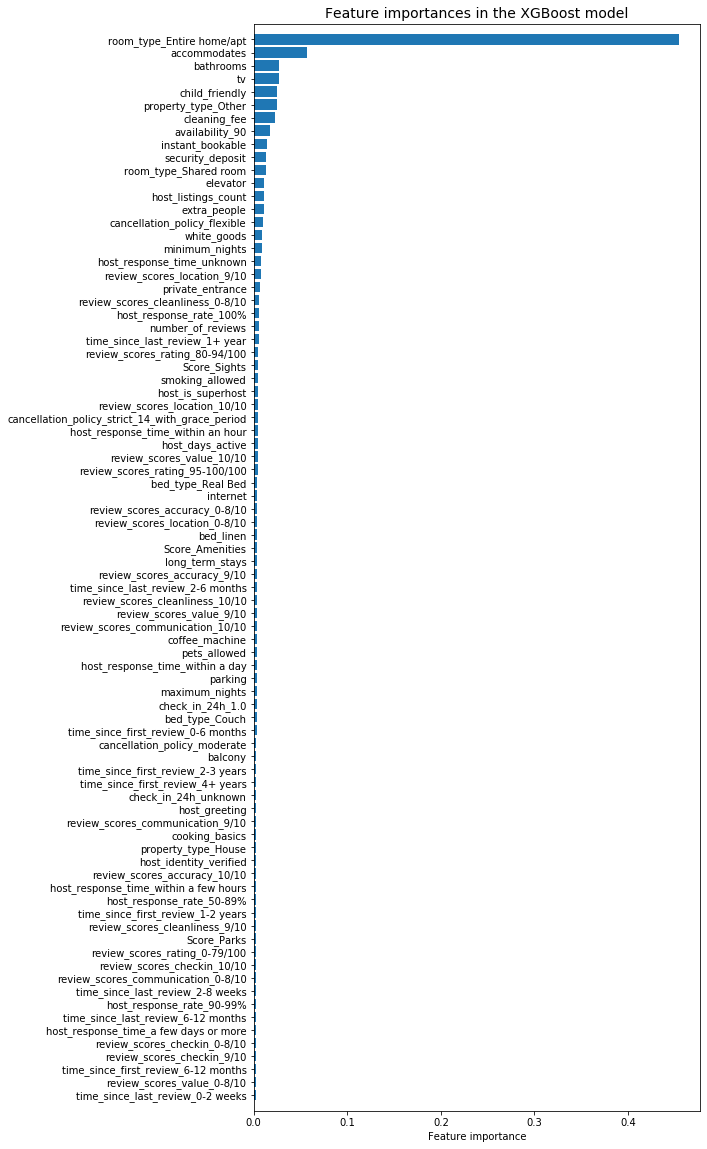

In [39]:
modelfit(xgb_default, df, useTrainCV=False)

Ok lets play around for a little bit.

In [40]:
df_constant = df
df_constant['accommodates'] = 1
df_constant['bathrooms'] = 1

In [41]:
# drop property and room type as we have size now
df_2 = df.drop(list(df.filter(regex = 'room_')), axis = 1)
df_3= df_2.drop(list(df_2.filter(regex = 'property_')), axis = 1)

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/anaconda3/envs/AirBnB/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Training MSE: 0.1382
Validation MSE: 0.1799

Training r2: 0.654
Validation r2: 0.5036
                                                   weight
accommodates                                     0.000000
bathrooms                                        0.000000
time_since_last_review_0-2 weeks                 0.004411
review_scores_checkin_9/10                       0.004732
review_scores_value_0-8/10                       0.005032
host_response_rate_90-99%                        0.005056
time_since_first_review_2-3 years                0.005151
time_since_first_review_1-2 years                0.005291
time_since_last_review_2-8 weeks                 0.005293
review_scores_checkin_10/10                      0.005401
time_since_first_review_6-12 months              0.005493
review_scores_rating_0-79/100                    0.005529
host_response_time_a few days or more            0.005531
review_scores_checkin_0-8/10                     0.005552
host_response_time_within a day            

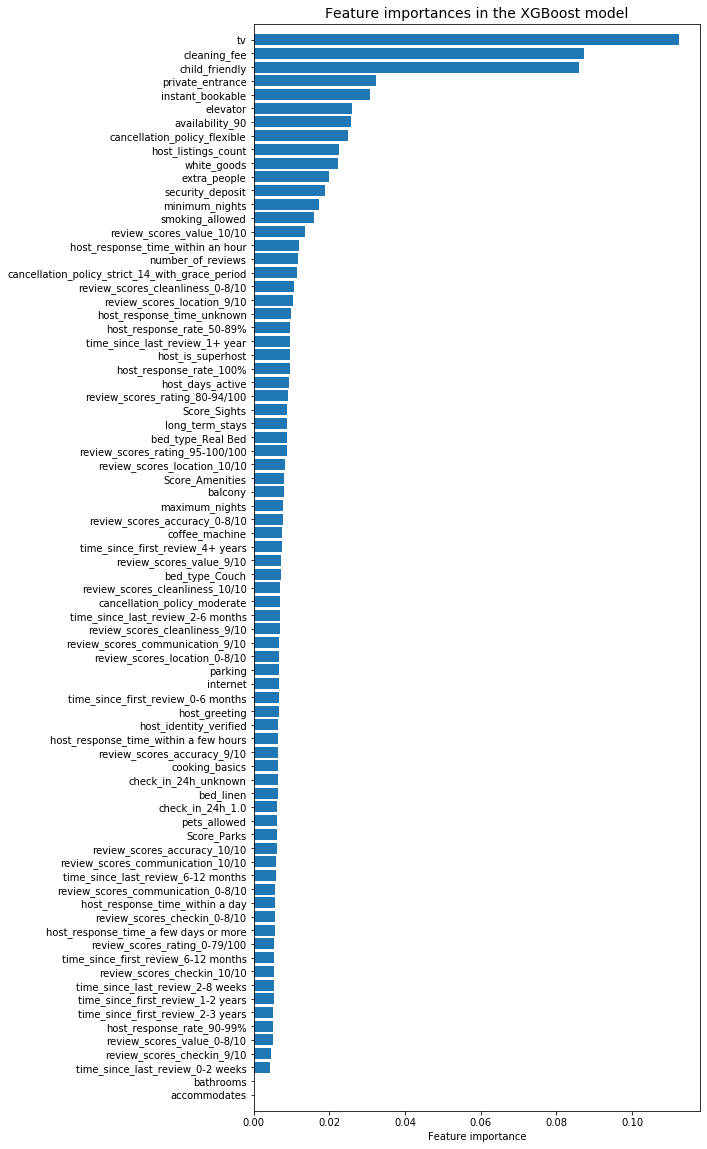

In [42]:
modelfit(xgb_default, df_3, useTrainCV=False)